In [2]:
#!L
backend = 'Colab' 

if backend == 'Colab':
    !pip install lpips
    !git clone https://github.com/yandexdataschool/deep_vision_and_graphics.git
    !sudo apt install -y ninja-build
    %cd /content/deep_vision_and_graphics/week09_gans


In [1]:
!wget https://www.dropbox.com/s/2kpsomtla61gjrn/pretrained.tar
!tar -xvf pretrained.tar

import sys
sys.path.append('/content/deep_vision_and_graphics/week09_gans')

In [1]:
#!L

import os
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt

print (torch.cuda.device_count())
print (torch.__version__)

import torchvision
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from tqdm.auto import tqdm, trange
from PIL import Image

from gans.gan_load import make_stylegan2


def to_image(tensor, adaptive=False):
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    if adaptive:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    else:
        tensor = ((tensor + 1) / 2).clamp(0, 1)

    return ToPILImage()((255 * tensor.cpu().detach()).to(torch.uint8))


def to_image_grid(tensor, adaptive=False, **kwargs):
    return to_image(make_grid(tensor, **kwargs), adaptive)

1
1.9.0+cu102


In [ ]:
!cd /content/Practical_DL

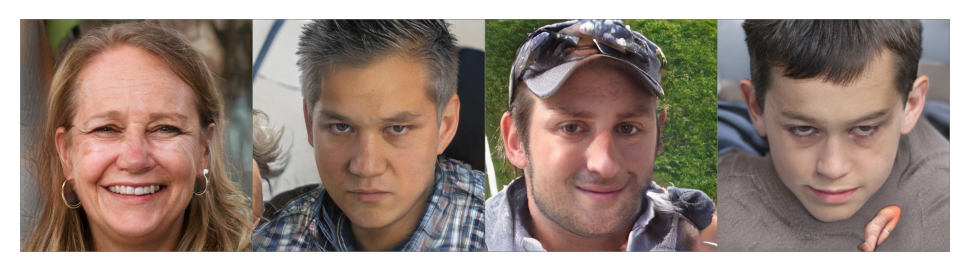

In [56]:
#!L
G = make_stylegan2(resolution=1024,
                   weights='pretrained/stylegan2-ffhq-config-f.pt', target_key='g').eval()


with torch.no_grad():
    z = torch.randn([4, 512]).cuda()
    w_mean = G.style_gan2.mean_latent(256)
    imgs = G(z)

plt.figure(dpi=200)
plt.axis('off')
plt.imshow(to_image_grid(imgs, nrow=6))

# Naive inversions

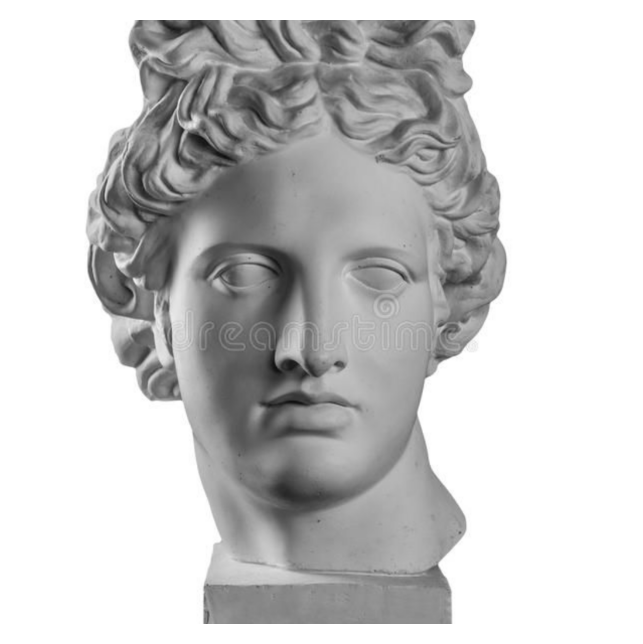

In [40]:
#!L
# download image
import requests
from io import BytesIO
from torchvision import transforms

zoom = 1.


def portrait_crop(img, h_percent, w_percent):
    w, h = img.size
    w_offset = int(0.5 * (1 - w_percent) * w)
    return img.crop([w_offset, 0, w - w_offset, int(h_percent * h)])


def load_image(img_url, zoom=1.0, w=1.0, h=1.0):
    crop = lambda x: portrait_crop(x, w, h)

    normalization = transforms.Compose([
        crop,
        transforms.Resize(int(zoom * 1024)),
        transforms.Resize(int(zoom * 1024)),
        transforms.CenterCrop(1024),
        transforms.ToTensor(),
        lambda x: 2 * x - 1,
    ])

    img_data = requests.get(img_url).content
    img = Image.open(BytesIO(img_data))
    return normalization(img).unsqueeze(0).cuda()


imgs = []
for link in [
             'https://fotorelax.ru/wp-content/uploads/2015/08/Daniel-Jacob-Radcliffe_6.jpg',
                'https://i.pinimg.com/736x/26/29/ca/2629ca7ed31a6867965d7f8e7a0c60c6.jpg'
            ]:
    imgs.append(load_image(link))
imgs = torch.cat(imgs)
img = imgs[0][None]


plt.figure(dpi=200)
plt.axis('off')
plt.imshow(to_image_grid(imgs))

In [32]:
#!L
import lpips
lpips_model = lpips.LPIPS()
lpips_model.cuda().eval()
lpips_dist = lambda x, y: lpips_model(
    F.interpolate(x, 256, mode='bilinear'),
    F.interpolate(y, 256, mode='bilinear'))

# CelebA regressor features extractor
face_fe = torchvision.models.resnet18()
face_fe.fc = nn.Sequential(nn.ReLU(), nn.Linear(512, 512), nn.ReLU())

state_dict = torch.load('pretrained/regressor.pth')['model_state_dict']
state_dict = {name[len('backbone.'):]: val for name, val in state_dict.items() if name.startswith('backbone.')}

face_fe.load_state_dict(state_dict)
face_fe.cuda().eval();

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Cache file:/home/avoin/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
Loading model from: /home/avoin/anaconda3/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [34]:
#!L
def invert(img, G, latent_init, n_steps=500, lr=0.025,
           l2_loss_scale=0.1, lpips_loss_scale=1.0, id_loss_scale=1.0,
           latent_map=lambda x: x, **g_kwargs):
    latent = nn.Parameter(latent_init.cuda())
    opt = torch.optim.Adam([latent,], lr=lr)

    l2_losses = []
    perceptual_losses = []
    id_losses = []
    losses = []
    for i in trange(n_steps):
        opt.zero_grad()

        reconstruction = G(latent_map(latent), **g_kwargs)
        l2_loss, perceptual_loss, id_loss = [torch.zeros([])] * 3
        if l2_loss_scale > 0.0:
            l2_loss = F.mse_loss(img, reconstruction).mean()
        if lpips_loss_scale > 0.0:
            perceptual_loss = lpips_dist(img, reconstruction).mean()
        if id_loss_scale > 0.0:
            id_loss = F.mse_loss(face_fe(img), face_fe(reconstruction)).mean()

        loss = l2_loss_scale * l2_loss + lpips_loss_scale * perceptual_loss + id_loss_scale * id_loss
        loss.backward()

        l2_losses.append(l2_loss.item())
        perceptual_losses.append(perceptual_loss.item())
        id_losses.append(id_loss.item())
        losses.append(loss.item())

        opt.step()
        if i % 100 == 0:
            print(f'{i}: loss: {np.mean(losses[-100:]): 0.2f}; '
                  f'l2-loss: {np.mean(l2_losses[-100:]): 0.2f}; '
                  f'lpips loss: {np.mean(perceptual_losses[-100:]): 0.2f}; '
                  f'id-loss: {np.mean(id_losses[-100:]): 0.2f}')

    return reconstruction, latent, losses


def show_inversion_result(img, reconstruction, losses=None):
    _, axs = plt.subplots(1, 3, dpi=250)
    for ax in axs[:2]: ax.axis('off')

    axs[0].imshow(to_image_grid(img))
    axs[1].imshow(to_image_grid(reconstruction))
    if losses is not None:
        axs[2].set_aspect(1.0 / np.max(losses) * len(losses))
        axs[2].set_title('Loss')
        axs[2].plot(losses)

0: loss:  0.71; l2-loss:  0.60; lpips loss:  0.62; id-loss:  0.03



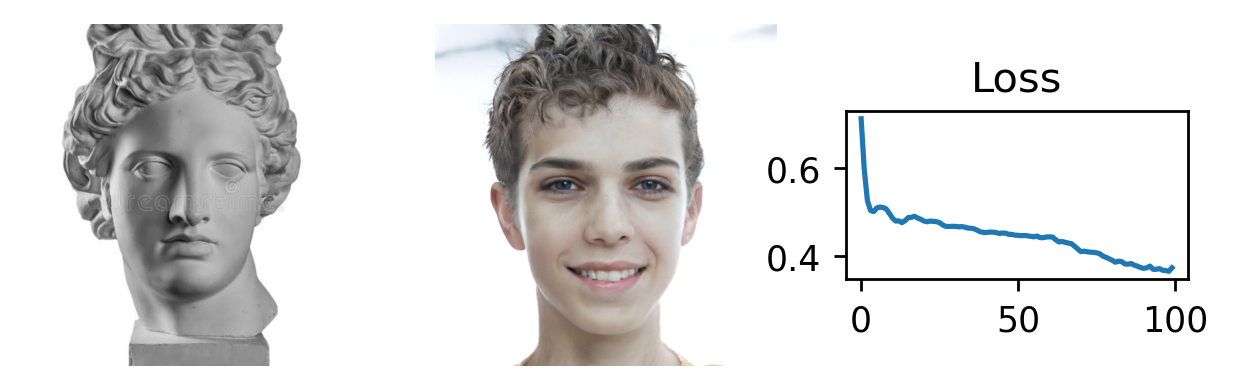

In [45]:
#!L
rec, z, losses = invert(img, G, torch.randn([1, G.dim_z]), n_steps=100,
                        l2_loss_scale=0.1, lpips_loss_scale=1.0, id_loss_scale=1.0)
show_inversion_result(img, rec, losses)

0: loss:  0.01; l2-loss:  0.00; lpips loss:  0.00; id-loss:  0.01



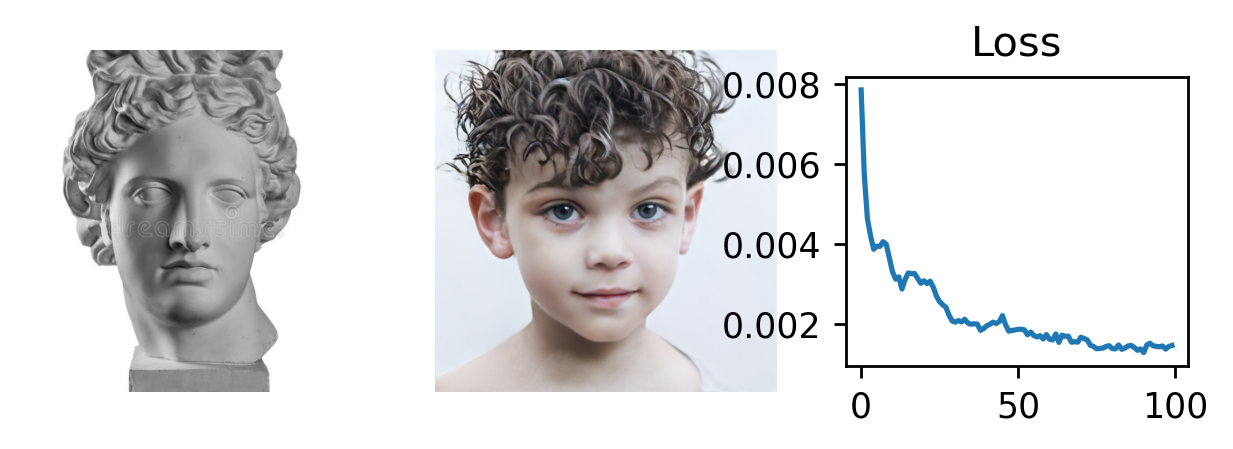

In [46]:
#!L
rec, z, losses = invert(img, G, z, n_steps=100,
                        l2_loss_scale=0.0, lpips_loss_scale=0.0, id_loss_scale=1.0)
show_inversion_result(img, rec, losses)

0: loss:  0.73; l2-loss:  0.78; lpips loss:  0.64; id-loss:  0.02
100: loss:  0.29; l2-loss:  0.12; lpips loss:  0.27; id-loss:  0.01
200: loss:  0.22; l2-loss:  0.08; lpips loss:  0.20; id-loss:  0.00
300: loss:  0.20; l2-loss:  0.08; lpips loss:  0.19; id-loss:  0.00
400: loss:  0.19; l2-loss:  0.08; lpips loss:  0.18; id-loss:  0.00



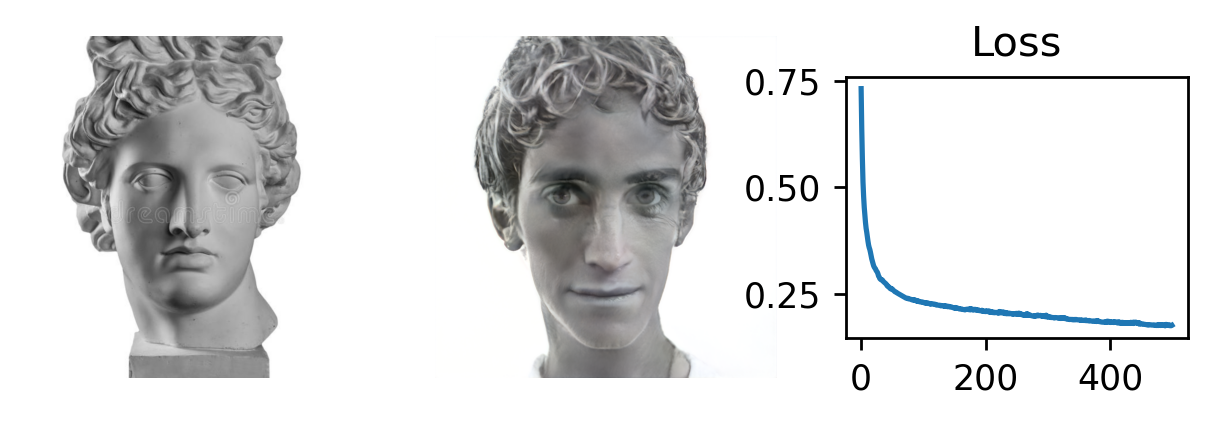

In [43]:
#!L
rec, w, losses = invert(img, G, w_mean, w_space=True, n_steps=500)
show_inversion_result(img, rec, losses)

0: loss:  0.61; l2-loss:  0.37; lpips loss:  0.56; id-loss:  0.02



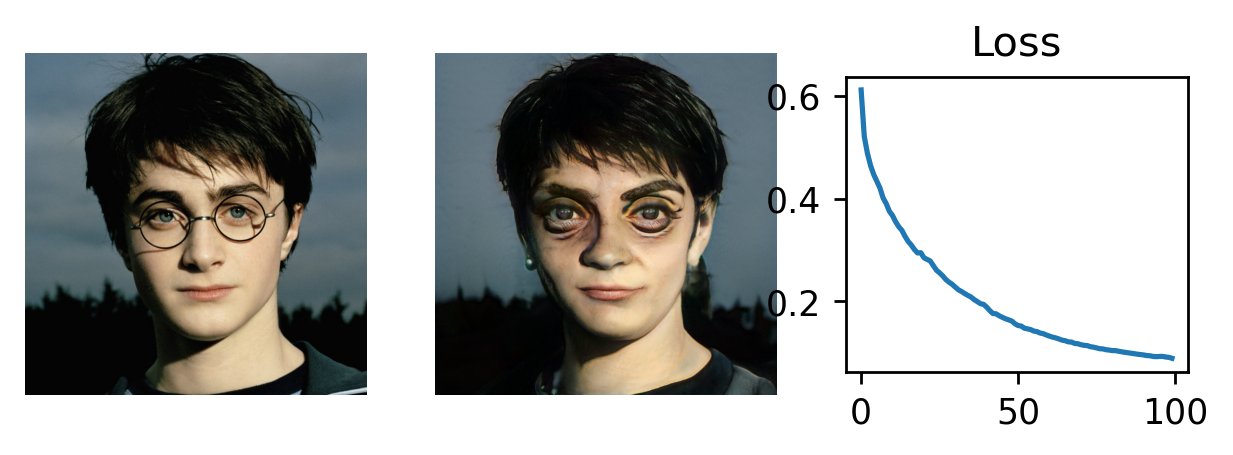

In [49]:
#!L
w_mean = G.style_gan2.mean_latent(64)
rec, w_plus, losses = invert(img, G, w_mean.unsqueeze(1).repeat(1, 18, 1), n_steps=100,
                             latent_map=lambda w_plus: [w_plus], w_space=True)
show_inversion_result(img, rec, losses)

# Pix2Style2Pix

cc: https://github.com/eladrich/pixel2style2pixel

In [19]:
!git clone https://github.com/eladrich/pixel2style2pixel
!touch pixel2style2pixel/__init__.py

fatal: destination path 'pixel2style2pixel' already exists and is not an empty directory.


In [37]:
#!L
import sys
sys.path.append('pixel2style2pixel')
from models.encoders.psp_encoders import GradualStyleEncoder
from argparse import Namespace

encoder_chkpt = torch.load('pretrained/psp_ffhq_encode.pt')
encoder = GradualStyleEncoder(50, 'ir_se', opts=Namespace(**encoder_chkpt['opts']))
encoder_state = {name[len('encoder.'):]: val for name, val in encoder_chkpt['state_dict'].items() \
                 if name.startswith('encoder')}

encoder.load_state_dict(encoder_state)
encoder.cuda().eval();
latent_mean = encoder_chkpt['latent_avg'].cuda()

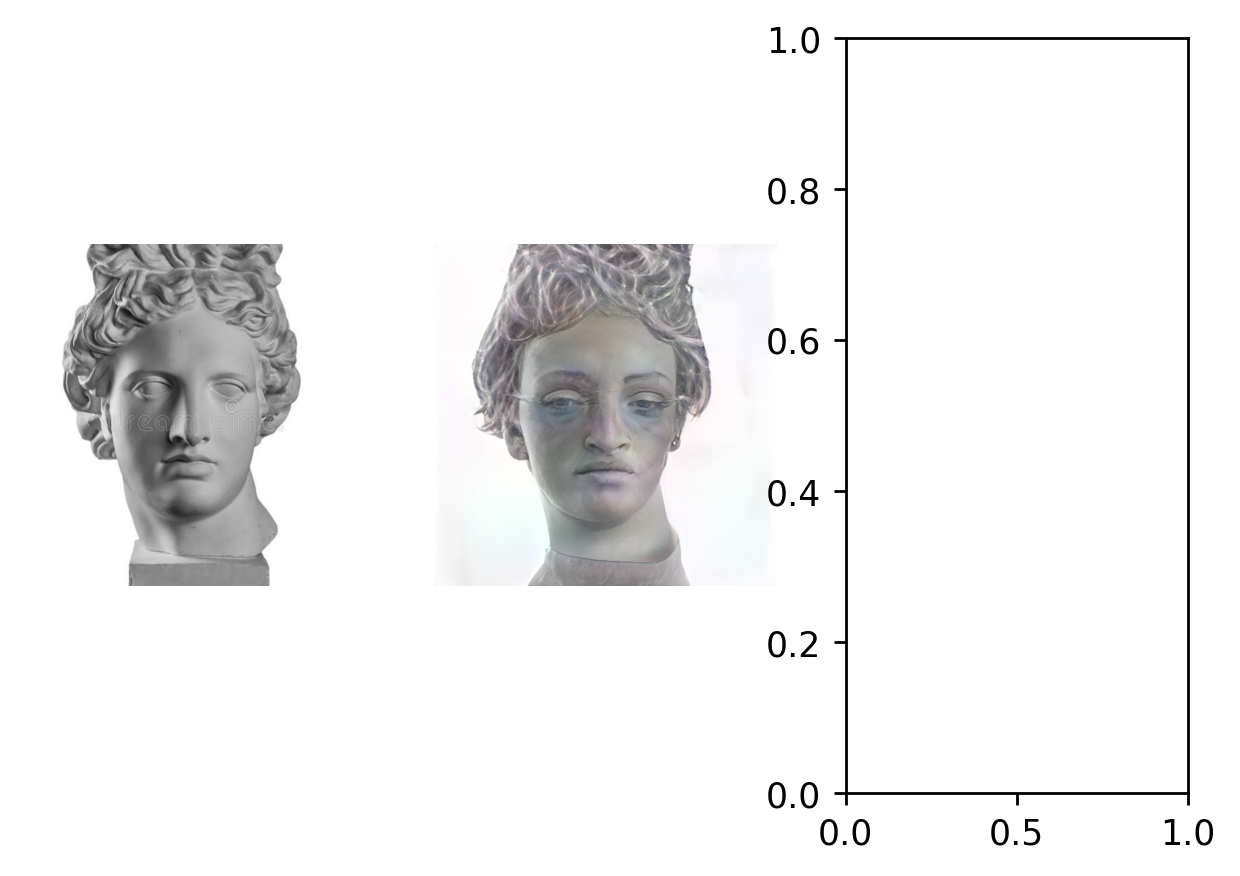

In [41]:
#!L
with torch.no_grad():
    w_inversion = encoder(F.interpolate(img, 256, mode='bilinear')) + latent_mean[None]
    rec = G([w_inversion], w_space=True)
show_inversion_result(img, rec)

### pix2style2pix with optimization

0: loss:  0.20; l2-loss:  0.06; lpips loss:  0.19; id-loss:  0.00



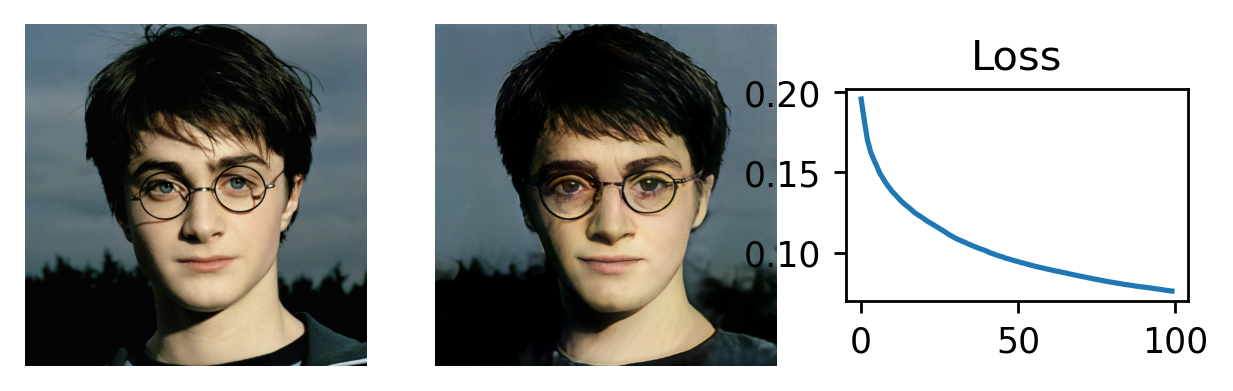

In [39]:
#!L
rec, w_plus, losses = invert(img, G, w_inversion, n_steps=100, lr=0.005,
                             latent_map=lambda w_plus: [w_plus], w_space=True)
show_inversion_result(img, rec, losses)

# CLIP + StyleGAN

cc: https://github.com/openai/CLIP

In [47]:
#!L
from CLIP.clip_wrapper import CLIPWrapper
clip = CLIPWrapper().cuda()

In [61]:
#!L
target_text = 'johnny depp'

with torch.no_grad():
    text_embed = clip.text_embed(target_text)

-0.220703125
-0.234130859375
-0.25048828125
-0.259765625
-0.2734375
-0.273193359375
-0.27978515625
-0.285400390625
-0.2783203125
-0.267578125



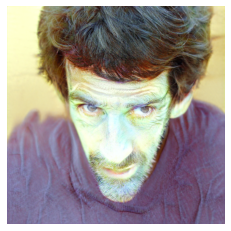

In [54]:
#!L
w_mean = G.style_gan2.mean_latent(64)
w = nn.Parameter(w_mean)
opt = torch.optim.Adam([w,], lr=0.005)


for i in trange(100):
    synth = G(w, w_space=True)
    img_embed = clip.clip_embed(synth)

    loss = -torch.cosine_similarity(img_embed, text_embed)
    loss.backward()
    if i % 10 == 0:
        print(loss.item())
    opt.step()
    
opt.zero_grad()

plt.axis('off')
plt.imshow(to_image(synth))

### add crop augmentations

0: -12.77 +  0.00
100: -33.31 +  0.68
200: -32.47 +  0.73



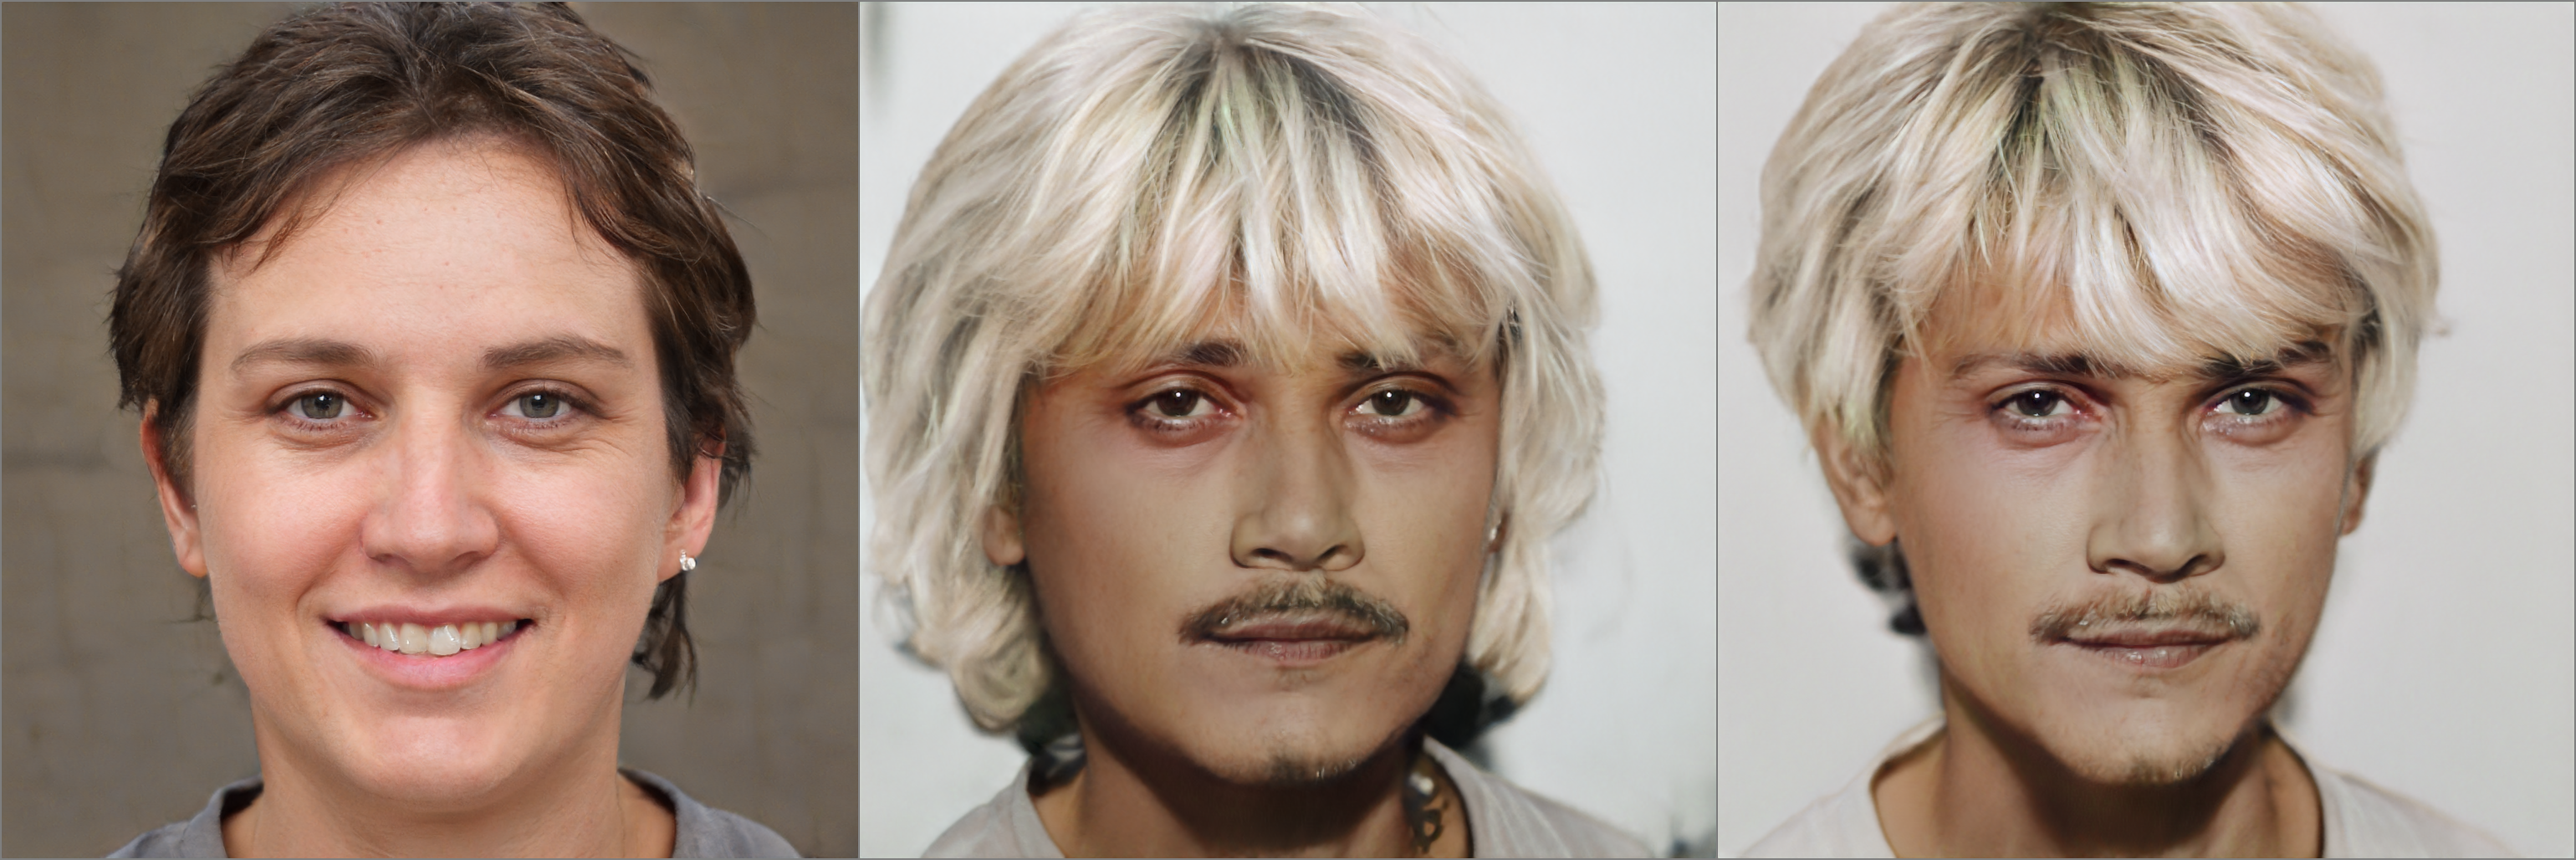

In [62]:
#!L
G = make_stylegan2(resolution=1024,
                   weights='pretrained/stylegan2-ffhq-config-f.pt', target_key='g').eval()


latent = nn.Parameter(w_mean.detach().clone())
opt_latent = torch.optim.Adam([latent,], lr=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt_latent, 0.995)

generated_imgs = []
n_steps = 201
save_every = 100
inversion_space = 'w'


for step in trange(n_steps):
    img = G(latent, w_space=True)
    side_x = img.shape[-1]

    crops = []
    for ch in range(4):
        size = int(side_x * torch.zeros(1,).normal_(mean=0.75, std=0.3).clip(0.5, 0.99))
        offset_x = torch.randint(0, side_x - size, ())
        offset_y = torch.randint(0, side_x - size, ())

        apper = img[:, :, offset_x: offset_x + size, offset_y: offset_y + size]
        apper = F.interpolate(apper, (224, 224), mode='nearest')
        crops.append(apper)

    crops = torch.cat(crops, dim=0)
    crops_embed = clip.clip_embed(crops)
    similarity_loss = -100 * torch.cosine_similarity(text_embed, crops_embed, dim=-1).mean()

    latent_loss = 0.0
    if inversion_space == 'z':
        latent_loss = latent.norm()
    elif inversion_space == 'w':
        latent_loss = (latent - w_mean).norm()
    latent_loss *= 0.1

    # optimize
    opt_latent.zero_grad()

    loss = similarity_loss + latent_loss
    loss.backward()

    opt_latent.step()
    scheduler.step()

    if step % save_every == 0:
        generated_imgs.append(img.detach().cpu())
        print(f'{step}: {similarity_loss.item(): 0.2f} + {latent_loss.item(): 0.2f}')

to_image_grid(torch.cat(generated_imgs))